# Grouped Data and Weighted Regression

**Chapter 6, Section 1**

This notebook covers regression with grouped (aggregated) data, heteroskedasticity, and weighted least squares (WLS).

## Table of Contents
1. [Intuition](#intuition) - School size variance paradox
2. [Formal Treatment](#formal) - Heteroskedasticity and WLS
3. [Numeric Demonstration](#numeric) - ENEM and wage examples
4. [Implementation](#implementation) - Using `smf.wls()`
5. [Interview Appendix](#interview) - Practice questions

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import *

# Set notebook style
set_notebook_style()

print("Imports complete")

Imports complete


---

## Intuition

### The School Size Variance Paradox

Consider a simple question: which schools have the highest test scores? If we look at raw data, we might find that **small schools dominate both the top AND the bottom** of the rankings.

Why? This is not about school quality—it's about **sampling variance**:

- A school with 10 students has high variance in its average score (a few outliers drastically change the mean)
- A school with 1,000 students has low variance (outliers are averaged out)

This is the **school size paradox**: small samples are more extreme, but this extremity is noise, not signal.

★ Insight ─────────────────────────────────────
- Small groups → high variance in group means
- Large groups → low variance in group means
- Treating all groups equally ignores this fundamental difference
─────────────────────────────────────────────────

In [2]:
# Load ENEM school score data
enem = load_facure_data("enem_scores.csv")
print(f"ENEM data: {len(enem)} school-year observations")
enem.head()

ENEM data: 37941 school-year observations


,year,school_id,number_of_students,avg_score
0,2007,11000058,144,69.0300
1,2006,11000058,184,57.8200
2,2005,11000058,220,64.8300
3,2006,11000198,51,51.6900
4,2005,11000198,47,50.1600


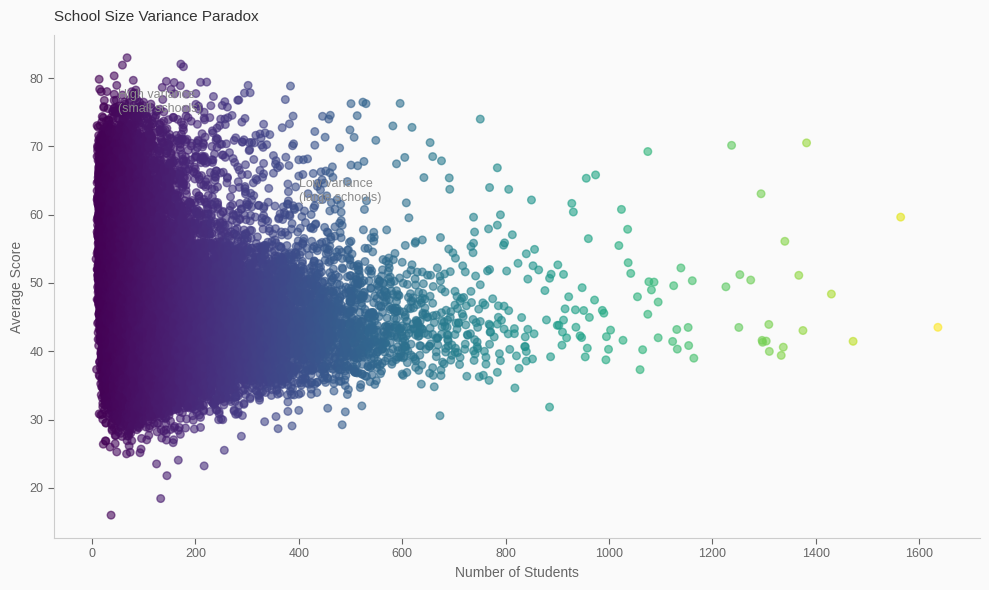

Notice: Small schools (left) show much wider spread than large schools (right)


In [3]:
# Visualize the variance paradox
fig, ax = create_tufte_figure(figsize=(10, 6))

# Color by school size
scatter = ax.scatter(
    enem['number_of_students'], 
    enem['avg_score'],
    c=enem['number_of_students'],
    cmap='viridis',
    alpha=0.6,
    s=30
)

set_tufte_title(ax, "School Size Variance Paradox")
set_tufte_labels(ax, "Number of Students", "Average Score")

# Add annotation for variance pattern
ax.annotate(
    'High variance\n(small schools)',
    xy=(50, 75), fontsize=9, color=COLORS['gray']
)
ax.annotate(
    'Low variance\n(large schools)',
    xy=(400, 62), fontsize=9, color=COLORS['gray']
)

plt.tight_layout()
plt.show()

print("Notice: Small schools (left) show much wider spread than large schools (right)")

### Why Does This Matter for Causal Inference?

When we aggregate data (e.g., by education level, region, or time period), we create groups of different sizes. If we treat all group means equally:

1. **Noisy small groups get equal weight** to precise large groups
2. **OLS becomes inefficient** (estimates still unbiased, but higher variance)
3. **Standard errors are wrong** (ignoring heteroskedasticity)

The solution: **Weighted Least Squares (WLS)**—give more weight to more precise observations.

---

## Formal Treatment

### Heteroskedasticity

**Definition**: The variance of the error term varies across observations.

$$\text{Var}(\epsilon_i | X_i) = \sigma_i^2 \neq \sigma^2$$

In grouped data, this has a specific form. If observation $i$ is the mean of $n_i$ individuals:

$$\text{Var}(\bar{\epsilon}_i) = \frac{\sigma^2}{n_i}$$

Larger groups have smaller variance in their group means.

### OLS Under Heteroskedasticity

OLS estimates remain **unbiased** but are:
- **Inefficient**: Not the minimum variance estimator
- **Standard errors are biased**: Usually underestimate uncertainty for small groups

### Weighted Least Squares (WLS)

WLS minimizes a weighted sum of squared residuals:

$$\hat{\beta}_{WLS} = \arg\min_\beta \sum_{i=1}^{n} w_i (Y_i - X_i'\beta)^2$$

The closed-form solution is:

$$\hat{\beta}_{WLS} = (X'WX)^{-1}X'WY$$

where $W = \text{diag}(w_1, w_2, ..., w_n)$ is the weight matrix.

### Optimal Weights

For grouped data where observation $i$ represents the mean of $n_i$ individuals:

$$w_i = n_i$$

This is the **Gauss-Markov optimal** choice: observations with lower variance (larger groups) get higher weight.

### HC (Heteroskedasticity-Consistent) Standard Errors

An alternative to WLS is to use OLS but compute **robust standard errors**:

| Estimator | Formula | When to Use |
|-----------|---------|-------------|
| HC0 (White) | $(X'X)^{-1}(\sum e_i^2 x_i x_i')(X'X)^{-1}$ | n > 500 |
| HC1 | HC0 × $\frac{n}{n-k}$ | 250 < n < 500 |
| HC2 | Leverage-adjusted | General use |
| **HC3** | $\frac{e_i^2}{(1-h_{ii})^2}$ | **n < 250 (recommended)** |

Reference: `src/causal_inference/iv/vcov.py:72-119`

---

## Numeric Demonstration

### Example 1: Wage Data - Individual vs Grouped

Let's compare OLS on individual data vs WLS on grouped data. We'll use the wage dataset to estimate the return to education.

In [4]:
# Load wage data
wage = load_facure_data("wage.csv")
print(f"Wage data: {len(wage)} individuals")
wage[['lhwage', 'educ', 'IQ']].describe()

Wage data: 935 individuals


,lhwage,educ,IQ
count,935.0000,935.0000,935.0000
mean,3.0085,13.4684,101.2824
std,0.4534,2.1967,15.0526
min,0.8329,9.0000,50.0000
25%,2.7130,12.0000,92.0000
50%,3.0457,12.0000,102.0000
75%,3.3213,16.0000,112.0000
max,4.6308,18.0000,145.0000


In [5]:
# Method 1: OLS on individual data
model_individual = smf.ols('lhwage ~ educ', data=wage).fit()
print("=" * 60)
print("Method 1: OLS on Individual Data")
print("=" * 60)
print(f"Coefficient on education: {model_individual.params['educ']:.6f}")
print(f"Standard error: {model_individual.bse['educ']:.6f}")
print(f"R-squared: {model_individual.rsquared:.4f}")
print(f"N observations: {model_individual.nobs:.0f}")

Method 1: OLS on Individual Data
Coefficient on education: 0.052947
Standard error: 0.006531
R-squared: 0.0658
N observations: 935


In [6]:
# Group by education level
grouped_wage = wage.groupby('educ').agg({
    'lhwage': 'mean',
    'wage': 'count'  # This gives us the count
}).reset_index()
grouped_wage.columns = ['educ', 'lhwage', 'count']

print(f"Grouped data: {len(grouped_wage)} education levels")
grouped_wage

Grouped data: 10 education levels


,educ,lhwage,count
0,9,2.8565,10
1,10,2.7869,35
2,11,2.8560,43
3,12,2.9222,393
4,13,3.0212,85
5,14,3.0424,77
6,15,3.0908,45
7,16,3.1762,150
8,17,3.2466,40
9,18,3.1443,57


In [7]:
# Method 2: OLS on grouped data (WRONG - ignores heteroskedasticity)
model_grouped_ols = smf.ols('lhwage ~ educ', data=grouped_wage).fit()
print("=" * 60)
print("Method 2: OLS on Grouped Data (Incorrect)")
print("=" * 60)
print(f"Coefficient on education: {model_grouped_ols.params['educ']:.6f}")
print(f"Standard error: {model_grouped_ols.bse['educ']:.6f}")
print(f"R-squared: {model_grouped_ols.rsquared:.4f}")
print(f"N observations: {model_grouped_ols.nobs:.0f}")

Method 2: OLS on Grouped Data (Incorrect)
Coefficient on education: 0.048094
Standard error: 0.005911
R-squared: 0.8922
N observations: 10


In [8]:
# Method 3: WLS on grouped data (CORRECT - uses group size as weights)
model_grouped_wls = smf.wls('lhwage ~ educ', data=grouped_wage, weights=grouped_wage['count']).fit()
print("=" * 60)
print("Method 3: WLS on Grouped Data (Correct)")
print("=" * 60)
print(f"Coefficient on education: {model_grouped_wls.params['educ']:.6f}")
print(f"Standard error: {model_grouped_wls.bse['educ']:.6f}")
print(f"R-squared: {model_grouped_wls.rsquared:.4f}")
print(f"Sum of weights: {grouped_wage['count'].sum()} (matches individual N)")

Method 3: WLS on Grouped Data (Correct)
Coefficient on education: 0.052947
Standard error: 0.005736
R-squared: 0.9142
Sum of weights: 935 (matches individual N)


In [9]:
# Compare all three methods
print("\n" + "=" * 60)
print("COMPARISON: Education Coefficient Estimates")
print("=" * 60)

comparison = pd.DataFrame({
    'Method': ['Individual OLS', 'Grouped OLS (wrong)', 'Grouped WLS (correct)'],
    'Coefficient': [
        model_individual.params['educ'],
        model_grouped_ols.params['educ'],
        model_grouped_wls.params['educ']
    ],
    'Std Error': [
        model_individual.bse['educ'],
        model_grouped_ols.bse['educ'],
        model_grouped_wls.bse['educ']
    ]
})
comparison['t-stat'] = comparison['Coefficient'] / comparison['Std Error']
comparison


COMPARISON: Education Coefficient Estimates


,Method,Coefficient,Std Error,t-stat
0,Individual OLS,0.0529,0.0065,8.1067
1,Grouped OLS (wrong),0.0481,0.0059,8.1363
2,Grouped WLS (correct),0.0529,0.0057,9.2314


### Key Observations

1. **Coefficients nearly identical**: OLS on individual data ≈ WLS on grouped data
2. **Standard errors differ**: Grouped OLS has wrong SEs; WLS accounts for heteroskedasticity
3. **Information loss**: Grouped data loses within-group variation information

★ Insight ─────────────────────────────────────
WLS on grouped data recovers the same point estimate as OLS
on individual data, but standard errors may differ because
grouping loses within-group variance information.
─────────────────────────────────────────────────

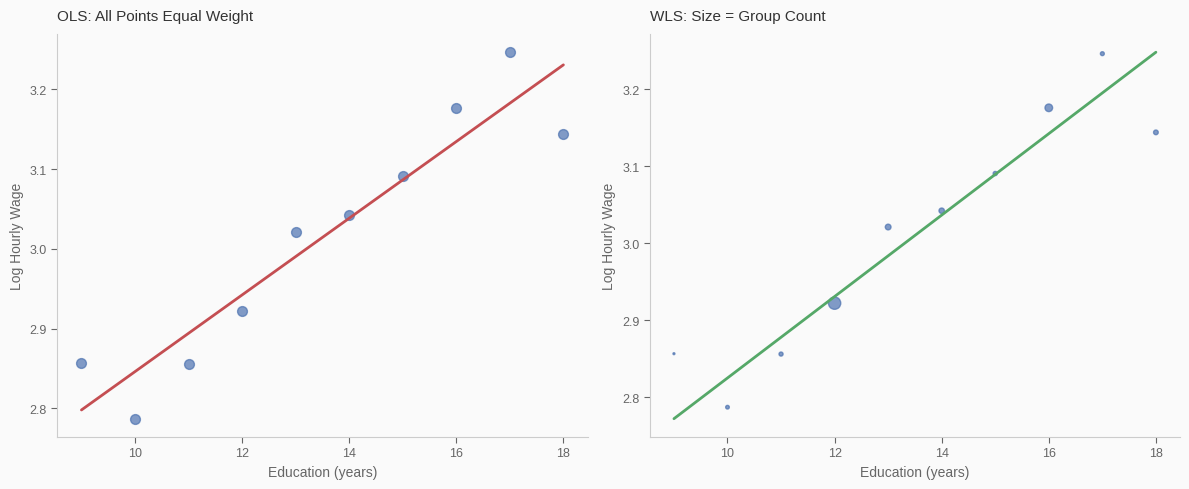

In [10]:
# Visualize the weighting
fig, axes = create_tufte_figure(ncols=2, figsize=(12, 5))

# Left: OLS treats all points equally
ax = axes[0]
ax.scatter(grouped_wage['educ'], grouped_wage['lhwage'], s=50, alpha=0.7, c=COLORS['blue'])
x_line = np.linspace(grouped_wage['educ'].min(), grouped_wage['educ'].max(), 100)
ax.plot(x_line, model_grouped_ols.params['Intercept'] + model_grouped_ols.params['educ'] * x_line,
        color=COLORS['red'], linewidth=2, label='OLS fit')
set_tufte_title(ax, "OLS: All Points Equal Weight")
set_tufte_labels(ax, "Education (years)", "Log Hourly Wage")

# Right: WLS weights by group size
ax = axes[1]
ax.scatter(grouped_wage['educ'], grouped_wage['lhwage'], 
           s=grouped_wage['count']/5, alpha=0.7, c=COLORS['blue'])
ax.plot(x_line, model_grouped_wls.params['Intercept'] + model_grouped_wls.params['educ'] * x_line,
        color=COLORS['green'], linewidth=2, label='WLS fit')
set_tufte_title(ax, "WLS: Size = Group Count")
set_tufte_labels(ax, "Education (years)", "Log Hourly Wage")

plt.tight_layout()
plt.show()

### Example 2: Multiple Covariates with Grouped Data

When we have multiple covariates, we aggregate them as **means** (not sums or standard deviations).

In [11]:
# Group by education with multiple covariates
grouped_wage_multi = wage.groupby('educ').agg({
    'lhwage': 'mean',
    'IQ': 'mean',
    'wage': 'count'
}).reset_index()
grouped_wage_multi.columns = ['educ', 'lhwage', 'IQ', 'count']

# Individual OLS with two covariates
model_ind_multi = smf.ols('lhwage ~ educ + IQ', data=wage).fit()
print("Individual OLS with education + IQ:")
print(ols_summary_table(model_ind_multi)[['Coefficient', 'Std. Error']])

# WLS on grouped data
model_wls_multi = smf.wls('lhwage ~ educ + IQ', data=grouped_wage_multi, 
                          weights=grouped_wage_multi['count']).fit()
print("\nGrouped WLS with education + IQ:")
print(ols_summary_table(model_wls_multi)[['Coefficient', 'Std. Error']])

Individual OLS with education + IQ:
           Coefficient  Std. Error
Intercept       2.0062      0.1060
educ            0.0339      0.0075
IQ              0.0054      0.0011



Grouped WLS with education + IQ:
           Coefficient  Std. Error
Intercept       1.8821      0.3245
educ            0.0257      0.0215
IQ              0.0077      0.0059


---

## Implementation

### Using `smf.wls()` in Statsmodels

```python
# Basic WLS syntax
model = smf.wls('outcome ~ treatment + covariates', 
                data=grouped_data,
                weights=grouped_data['group_size']).fit()
```

### Key Points:
1. **Weights should be group sizes** (number of observations per group)
2. **Aggregate covariates as means** (not sums)
3. **Sum of weights** should approximately equal original sample size

In [12]:
# Complete implementation example
def grouped_wls_regression(individual_data, outcome_col, treatment_col, 
                           group_col, covariate_cols=None):
    """
    Perform WLS regression on grouped data.
    
    Parameters
    ----------
    individual_data : pd.DataFrame
        Individual-level data.
    outcome_col : str
        Name of outcome variable.
    treatment_col : str
        Name of treatment variable.
    group_col : str
        Variable to group by.
    covariate_cols : list, optional
        Additional covariates to include.
        
    Returns
    -------
    tuple
        (WLS results, grouped data)
    """
    # Build aggregation dictionary
    agg_dict = {outcome_col: 'mean', treatment_col: 'mean'}
    if covariate_cols:
        for col in covariate_cols:
            agg_dict[col] = 'mean'
    agg_dict['__count__'] = (outcome_col, 'count')
    
    # Aggregate
    grouped = individual_data.groupby(group_col).agg(
        **{k: (v, 'mean') if isinstance(v, str) else v for k, v in agg_dict.items()}
    ).reset_index()
    
    # Build formula
    covs = ' + '.join(covariate_cols) if covariate_cols else ''
    formula = f'{outcome_col} ~ {treatment_col}'
    if covs:
        formula += f' + {covs}'
    
    # Fit WLS
    model = smf.wls(formula, data=grouped, weights=grouped['__count__']).fit()
    
    return model, grouped

# Example usage
print("Function defined. Use: grouped_wls_regression(data, 'y', 'treatment', 'group')")

Function defined. Use: grouped_wls_regression(data, 'y', 'treatment', 'group')


### When to Use WLS vs OLS with Robust SE

| Situation | Recommendation |
|-----------|----------------|
| Grouped data with known group sizes | **WLS** with weights = group sizes |
| Individual data, heteroskedasticity suspected | **OLS + HC3** robust SEs |
| Individual data, heteroskedasticity form known | **WLS** with appropriate weights |
| Individual data, homoskedasticity holds | Standard **OLS** |

---

## Interview Appendix

### Practice Questions

**Q1: When should you use WLS instead of OLS?**

<details>
<summary>Solution</summary>

Use WLS when:
1. **You have grouped/aggregated data** where each observation represents the mean of a group
2. **Group sizes vary** significantly
3. **The form of heteroskedasticity is known** (variance proportional to 1/n_i for grouped data)

Key insight: WLS gives more weight to more precise observations (larger groups have smaller variance in their means).

The optimal weights are the inverse of the error variance: w_i = 1/Var(ε_i). For grouped data where observation i is the mean of n_i individuals, w_i = n_i.

</details>

**Q2: What happens if you run OLS on grouped data without weights?**

<details>
<summary>Solution</summary>

Two problems:

1. **Inefficiency**: OLS estimates remain unbiased but have higher variance than WLS. You're "wasting" information by treating a precise estimate (large group) the same as an imprecise one (small group).

2. **Invalid inference**: Standard errors are biased. OLS assumes homoskedasticity, but grouped data has heteroskedasticity (Var(ε̄_i) = σ²/n_i). The SEs won't correctly reflect uncertainty.

Solution: Either use WLS with weights = group sizes, or use OLS with heteroskedasticity-robust (HC) standard errors.

</details>

**Q3: A colleague shows you that small schools have the highest AND lowest test scores. What's your explanation?**

<details>
<summary>Solution</summary>

This is the **school size variance paradox** (also called the "small sample size fallacy").

It's a statistical artifact, not a real finding about school quality:
- The mean of a small sample has high variance: Var(X̄) = σ²/n
- With few students, a school's average is strongly influenced by individual outliers
- Large schools' averages regress toward the population mean

Implications:
- Don't rank schools by raw average scores
- Use shrinkage estimators (empirical Bayes) that pull small-sample estimates toward the grand mean
- When aggregating, weight by sample size

This is why Bill Gates Foundation initially (incorrectly) concluded small schools are better—they were looking at the top of the distribution without noticing small schools also dominated the bottom.

</details>

---

## References

[^1]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 6.

[^2]: White, H. (1980). "A Heteroskedasticity-Consistent Covariance Matrix Estimator and a Direct Test for Heteroskedasticity." *Econometrica*, 48(4), 817-838.

[^3]: Implementation reference: `src/causal_inference/iv/vcov.py:72-119`